# Convolutional Autoencoder Training for Anomaly Detection @ L1Trigger

## Packages

In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc

import keras_tuner
from keras_tuner import Hyperband

import joblib

## Read input files

All input files are already sorted in Calo regions (i, j) ~ (18, 14)<br>
Where i = 0 -> 17 corresponds to GCT_Phi = 0 -> 17<br>
Where j = 0 -> 13 corresponds to RCT_Eta = 4 -> 17

Keep this ordering as is when feeding into neural nets. Also keep this in mind when generating/preparing new samples.

### Backgrounds

In [2]:
ZeroBias = np.concatenate((h5py.File('bkg/ZeroBias_0.h5', 'r')['CaloRegions'][()],
                           h5py.File('bkg/ZeroBias_1.h5', 'r')['CaloRegions'][()],
                           h5py.File('bkg/ZeroBias_2.h5', 'r')['CaloRegions'][()]))
ZeroBias = ZeroBias.astype(dtype = 'float32').reshape(-1, 18, 14, 1)
print('ZeroBias shape: ' + str(ZeroBias.shape))

MC_files = []
MC_files.append('bkg/110X/QCD_0.h5')#i=0
#MC_files.append('bkg/110X/QCD_1.h5')
#MC_files.append('bkg/110X/QCD_2.h5')
MC_files.append('bkg/120X/SingleNeutrino_E-10_0.h5')#i=1
#MC_files.append('bkg/120X/SingleNeutrino_E-10_1.h5')
#MC_files.append('bkg/120X/SingleNeutrino_E-10_2.h5')
MC_files.append('bkg/120X/SingleNeutrino_Pt-2To20_0.h5')#i=2
#MC_files.append('bkg/120X/SingleNeutrino_Pt-2To20_1.h5')
#MC_files.append('bkg/120X/SingleNeutrino_Pt-2To20_2.h5')

MC_files.append('sig/110X/GluGluToHHTo4B_node_SM_TuneCP5_14TeV.h5')#i=3
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5')
MC_files.append('sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5')
MC_files.append('sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M100_pT300_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M200_pT300_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M50_pT300_TuneCP5_14TeV.h5')#i=13
MC_files.append('sig/110X/ZprimeToZH_MZprime1000_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/ZprimeToZH_MZprime600_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/ZprimeToZH_MZprime800_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-9000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')#i=23
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-15000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-30000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-60_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5')#i=33
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV-pythia814TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-120_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-350_TuneCP5_14TeV.h5')#i=43
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-600_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/TprimeBToTH_M-650_LH_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHHTo4B_CV_1_C2V_2_C3_1_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHToInvisible_M125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHToTauTau_M125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeGammaToQQGamma_M-10_GPt-75_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeToQQ_M-100_Pt-300_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeToQQ_M-200_Pt-300_TuneCP5_14TeV.h5')#i=51

MC = []
AcceptanceFlag = []
for i in range(len(MC_files)):
    MC.append(h5py.File(MC_files[i], 'r')['CaloRegions'][()].astype(dtype = 'float32'))
    MC[i] = MC[i].reshape(-1, 18, 14, 1)
    #Read acceptance flag in MC signals
    if i > 2:
        AcceptanceFlag.append(h5py.File(MC_files[i], 'r')['AcceptanceFlag'][()])
    else:
        AcceptanceFlag.append(np.ones((MC[i].shape[0])))
    
MC[0] = MC[0][:100000,:,:,:]#QCD
MC[1] = MC[1][:100000,:,:,:]#SingleNu_E10
MC[2] = MC[2][:100000,:,:,:]#SingleNu_Pt2To20

'''
#/nfs_scratch/dasu/2022-02-04/L1TSignalZerobiasMixer/cms-vbfh.csv
vbf = pd.read_csv('cms-vbfh.csv')
vbf.columns = ['eta','phi','et','pos','ebit','tbit']
vbf = vbf[251:]

event_col = []
for i in range(round(vbf.shape[0]/252)):
    for j in range(252):
        event_col.append(i)
        
vbf['event'] = event_col
vbf = vbf.drop(['pos','ebit','tbit'],axis=1)
vbf = vbf.sort_values(by=['event', 'phi', 'eta'], ascending = [True, True, True])
vbf = vbf.reindex(columns=['event','phi','eta','et'])
vbf = vbf.drop(['event'],axis=1)
vbf = vbf.to_numpy()
vbf = vbf.reshape((-1,18,14,3))
vbf = vbf[:,:,:,2]
vbf = vbf.reshape((-1,18,14,1))
vbf.shape
MC_files.append('/nfs_scratch/dasu/2022-02-04/L1TSignalZerobiasMixer/cms-vbfh.csv')
MC.append(vbf)
'''

#Throw away MC signal events that failed to pass the acceptance cuts
acceptance_filter = []
for i in range(len(MC_files)):
    acceptance_filter.append([])
    for j in range(MC[i].shape[0]):
        if AcceptanceFlag[i][j] == 1:
            acceptance_filter[i].append(True)
        else:
            acceptance_filter[i].append(False)
    MC[i] = MC[i][acceptance_filter[i],:,:,:]
    print('i = ' + str(i) + ': ' + str(MC[i].shape) + '; accepted ' + str(np.round(np.mean(AcceptanceFlag[i]), 4)))

ZeroBias shape: (315766, 18, 14, 1)
i = 0: (100000, 18, 14, 1); accepted 1.0
i = 1: (100000, 18, 14, 1); accepted 1.0
i = 2: (100000, 18, 14, 1); accepted 1.0
i = 3: (49931, 18, 14, 1); accepted 0.9986
i = 4: (39851, 18, 14, 1); accepted 1.0
i = 5: (34589, 18, 14, 1); accepted 0.8647
i = 6: (11334, 18, 14, 1); accepted 0.8718
i = 7: (35599, 18, 14, 1); accepted 0.89
i = 8: (291352, 18, 14, 1); accepted 0.9712
i = 9: (29879, 18, 14, 1); accepted 0.996
i = 10: (279275, 18, 14, 1); accepted 0.9597
i = 11: (1853, 18, 14, 1); accepted 0.9995
i = 12: (38011, 18, 14, 1); accepted 0.9997
i = 13: (6279, 18, 14, 1); accepted 0.999
i = 14: (49993, 18, 14, 1); accepted 0.9999
i = 15: (49845, 18, 14, 1); accepted 0.9969
i = 16: (49969, 18, 14, 1); accepted 0.9994
i = 17: (273519, 18, 14, 1); accepted 0.9117
i = 18: (99843, 18, 14, 1); accepted 0.9984
i = 19: (99323, 18, 14, 1); accepted 0.9932
i = 20: (39987, 18, 14, 1); accepted 1.0
i = 21: (39985, 18, 14, 1); accepted 1.0
i = 22: (31505, 18, 14, 

In [3]:
#Throw away events with max pt > 1023 GeV (the Calo system cannot produce more than that)
filter1023_zb = []
for i in range(ZeroBias.shape[0]):
    if ZeroBias[i,:,:,0].max() > 1023:
        filter1023_zb.append(False)
    else:
        filter1023_zb.append(True)
ZeroBias = ZeroBias[filter1023_zb,:,:,:]
print('ZeroBias shape = ' + str(ZeroBias.shape) + '; fraction left = ' + str(round(ZeroBias.shape[0]/len(filter1023_zb),4)))

filter1023_mc = []
for i in range(len(MC_files)):
    filter1023_mc.append([])
    for j in range(MC[i].shape[0]):
        if MC[i][j,:,:,0].max() > 1023:
            filter1023_mc[i].append(False)
        else:
            filter1023_mc[i].append(True)
    MC[i] = MC[i][filter1023_mc[i],:,:,:]
    print('i = ' + str(i) + ': ' + str(MC[i].shape) + '; fraction left = ' + str(round(MC[i].shape[0]/len(filter1023_mc[i]),4)))

ZeroBias shape = (315766, 18, 14, 1); fraction left = 1.0
i = 0: (89972, 18, 14, 1); fraction left = 0.8997
i = 1: (100000, 18, 14, 1); fraction left = 1.0
i = 2: (100000, 18, 14, 1); fraction left = 1.0
i = 3: (49560, 18, 14, 1); fraction left = 0.9926
i = 4: (39329, 18, 14, 1); fraction left = 0.9869
i = 5: (34574, 18, 14, 1); fraction left = 0.9996
i = 6: (11329, 18, 14, 1); fraction left = 0.9996
i = 7: (35583, 18, 14, 1); fraction left = 0.9996
i = 8: (291258, 18, 14, 1); fraction left = 0.9997
i = 9: (29840, 18, 14, 1); fraction left = 0.9987
i = 10: (279195, 18, 14, 1); fraction left = 0.9997
i = 11: (1774, 18, 14, 1); fraction left = 0.9574
i = 12: (36548, 18, 14, 1); fraction left = 0.9615
i = 13: (5956, 18, 14, 1); fraction left = 0.9486
i = 14: (47706, 18, 14, 1); fraction left = 0.9543
i = 15: (49778, 18, 14, 1); fraction left = 0.9987
i = 16: (49646, 18, 14, 1); fraction left = 0.9935
i = 17: (273483, 18, 14, 1); fraction left = 0.9999
i = 18: (99749, 18, 14, 1); fraction 

In [ ]:
#Many ways to pre-process the input Et, but should fix the transformation and apply the same for all
#instead of one mapping for this batch and another mapping for another batch)
#Normalize region Et to 1.0 by dividing by the max acceptable 1023 GeV
ZeroBias = ZeroBias/1023.0
for i in range(len(MC_files)):
    MC[i] = MC[i]/1023.0

## Create overlaid samples (ZB + MC) for test

In [4]:
#Overlay MC events on top of ZB before testing
#Simple addition tower by tower: overlaid MC = ZB + MC
#ZB is chosen at random for each MC event before overlaying them
np.random.seed(0)
MC_zb = []
for i in range(len(MC)):
    MC_zb.append(np.empty((MC[i].shape[0], 18, 14, 1)))
    ZB_random_event = np.random.randint(low = 0, high = ZeroBias.shape[0], size = MC[i].shape[0])
    for j in range(MC[i].shape[0]):
        MC_zb[i][j, :, :, 0] = ZeroBias[ZB_random_event[j], :, :, 0] + MC[i][j, :, :, 0]

In [ ]:
#Plot and compare signals/QCD/SingleNu before and after the overlay
#n = 0 (QCD), 1 (SingleNu_E10), 2 (SingleNu_Pt2To20), 3... (signals)
n = 5
for i in range(40,50):
    fig, ax = plt.subplots(figsize = (10,10))
    print(str(MC_files[n]))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(MC[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('MC')
    
    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(MC_zb[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('MC+ZB')
    
    plt.show()

## ZeroBias statistics

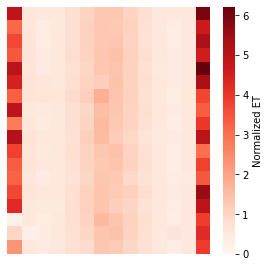

In [5]:
ZB_mean = np.mean(ZeroBias, axis = 0)

fig, ax = plt.subplots(figsize = (10,10))
ax = plt.subplot(2, 2, 1)
ax = sns.heatmap(ZB_mean.reshape(18, 14), vmin = 0, vmax = ZB_mean.max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

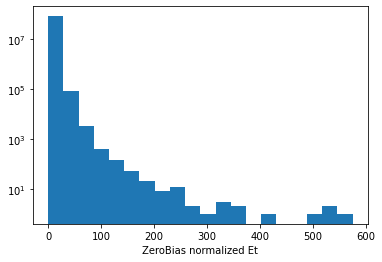

Mean ZeroBias pT= 1.227905


In [6]:
plt.hist(ZeroBias.reshape((-1)), bins = 20, log = True)
plt.xlabel("ZeroBias normalized Et")
plt.show()

print('Mean ZeroBias pT= ' + str(np.mean(ZeroBias.reshape(-1))))

In [ ]:
#Apply pT cut on ZeroBias training data?
pt_filter = []
for i in range(ZeroBias.shape[0]):
    if ZeroBias[i,:,:,0].max() < 30.0/1023.0:
        pt_filter.append(True)
    else:
        pt_filter.append(False)
ZeroBias_ptcut = ZeroBias[pt_filter,:,:,:]

## Models

### Optimal hyperparameters searching

In [7]:
import tensorflow.keras.backend as K
def custom_loss_for_train():
    def func(y_true, y_pred):
        #MSE(output, input)
        loss = K.mean((y_pred - y_true)**2, axis = [1, 2, 3])
        
        #MSE(output, mean ZB)
        #loss = K.mean((y_pred - ZB_mean)**2, axis = [1, 2, 3])
        
        #MSE(output, 0) for denoising
        #loss = K.mean(y_pred**2, axis = [1, 2, 3])
        
        return loss
    return func

In [ ]:
#Define hypermodel for the search
def hypermodel(hp):
    hp_model = tf.keras.Sequential()
    hp_model.add(tf.keras.layers.InputLayer(input_shape = (18, 14, 1)))
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_1',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.AveragePooling2D((2, 2)))
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_2',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2D(filters = 1,
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_3',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.UpSampling2D((2, 2)))
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_4',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'relu', strides = 1, padding = 'same'))
    hp_model.compile(optimizer = 'adam', loss = custom_loss_for_train())
    return hp_model

In [25]:
#Hyperparameters search for student (dense) model
def hypermodel(hp):
    hp_model = tf.keras.Sequential()
    hp_model.add(tf.keras.layers.InputLayer(input_shape = (18, 14, 1)))
    hp_model.add(tf.keras.layers.Flatten())
    hp_model.add(tf.keras.layers.Dense(units = hp.Int('units_1',
                                                      min_value = 10,
                                                      max_value = 40,
                                                      step = 2),
                                       activation = 'relu'))
    hp_model.add(tf.keras.layers.Dropout(rate = 0.3))
    hp_model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    hp_model.compile(optimizer = 'adam', loss = 'mse')
    return hp_model

In [27]:
#Define tuner model
tuner = Hyperband(hypermodel,
                 objective = 'val_loss',
                 max_epochs = 20,
                 factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                 hyperband_iterations = 2, #number of times to iterate over the full Hyperband algorithm
                 seed = 10,
                 directory = 'hypertuning',
                 project_name = 'tune',
                 overwrite = True)

In [ ]:
#Partition the whole training set into train/val/test sets
X = ZeroBias

train_ratio = 0.5
val_ratio = 0.15
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

In [28]:
#Run the search
tuner.search(X_train, 100.*X_train_loss,
            epochs = 20,
            validation_data = (X_val, 100.*X_val_loss),
            batch_size = 256)

Trial 21 Complete [00h 00m 25s]
val_loss: 1450.9195556640625

Best val_loss So Far: 1343.9644775390625
Total elapsed time: 00h 06m 09s
INFO:tensorflow:Oracle triggered exit


In [29]:
#Show best sets of hyperparameters
tuner.results_summary(num_trials = 3)

Results summary
Results in hypertuning/tune
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units_1: 38
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 7456d380b6095c4cbe1ef2839b0049ea
Score: 1343.9644775390625
Trial summary
Hyperparameters:
units_1: 26
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: c225e106a988b04d2c4daa21d2dfdb08
Score: 1433.9931640625
Trial summary
Hyperparameters:
units_1: 40
tuner/epochs: 7
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1450.9195556640625


In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)
model.summary()

### Create model

#### ConvAE model

In [8]:
encoder_input = tf.keras.Input(shape = (18, 14, 1))
encoding = layers.Conv2D(21, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_input)
encoding = layers.AveragePooling2D((2, 2))(encoding)
encoding = layers.Conv2D(19, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)

encoder_output = layers.Conv2D(1, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)

encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 14, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 14, 21)        210       
_________________________________________________________________
average_pooling2d (AveragePo (None, 9, 7, 21)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 7, 19)          3610      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 1)           172       
Total params: 3,992
Trainable params: 3,992
Non-trainable params: 0
_________________________________________________________________


2022-04-26 22:28:21.124848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-26 22:28:21.125039: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
#Conv2DTranspose not supported by hls4ml
decoding = layers.Conv2D(25, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_output)
decoding = layers.UpSampling2D((2, 2))(decoding)
decoding = layers.Conv2D(25, (3, 3), activation = 'relu', strides = 1, padding = 'same')(decoding)

decoder_output = layers.Conv2D(1, (3, 3), activation = 'relu', strides = 1, padding = 'same')(decoding)

In [10]:
model = tf.keras.Model(encoder_input, decoder_output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 14, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 14, 21)        210       
_________________________________________________________________
average_pooling2d (AveragePo (None, 9, 7, 21)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 7, 19)          3610      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 1)           172       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 7, 25)          250       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 18, 14, 25)        0   

In [11]:
model.compile(optimizer = 'adam', loss = 'mse')
#model.compile(optimizer = 'adam', loss = custom_loss_for_train())

#### Dense model

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = (18, 14, 1)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(20, activation = 'relu'))
model.add(tf.keras.layers.Dense(20, activation = 'relu'))
model.add(tf.keras.layers.Dense(10, activation = 'relu'))
model.add(tf.keras.layers.Dense(20 , activation = 'relu'))
model.add(tf.keras.layers.Dense(20 , activation = 'relu'))
model.add(tf.keras.layers.Dense(252 , activation = 'sigmoid'))
model.add(tf.keras.layers.Reshape((18, 14, 1)))
model.summary()
model.compile(optimizer = 'adam', loss = 'mse')

#### De-noising model

In [ ]:
encoder_input = tf.keras.Input(shape = (18, 14, 1))
encoding = layers.Conv2D(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_input)
encoding = layers.AveragePooling2D((2, 2))(encoding)
encoding = layers.Conv2D(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)

encoder_output = layers.Conv2D(2, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)

encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()

In [ ]:
decoding = layers.Conv2D(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_output)
decoding = layers.UpSampling2D((2, 2))(decoding)
decoding = layers.Conv2D(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(decoding)

decoder_output = layers.Conv2D(1, (3, 3), activation = 'sigmoid', strides = 1, padding = 'same')(decoding)

In [ ]:
model = tf.keras.Model(encoder_input, decoder_output)
model.summary()

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
#model.compile(optimizer = 'adam', loss = 'mse')

### Training

In [12]:
#Re-partition the whole training set into train/val/test sets
X = ZeroBias

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

In [ ]:
#Training data preparation for de-noising model
np.random.seed(0)

RandomTowers = np.zeros((ZeroBias.shape[0], 18, 14, 1))

random_phi1 = np.random.randint(low = 1, high = 17, size = np.int(RandomTowers.shape[0]/2))
random_eta1 = np.random.randint(low = 1, high = 13, size = np.int(RandomTowers.shape[0]/2))
random_pt1 = np.random.randint(low = 30, high = 100, size = np.int(RandomTowers.shape[0]/2))
random_phi2 = np.random.randint(low = 1, high = 17, size = np.int(RandomTowers.shape[0]/2))
random_eta2 = np.random.randint(low = 1, high = 13, size = np.int(RandomTowers.shape[0]/2))
random_pt2 = np.random.randint(low = 30, high = 100, size = np.int(RandomTowers.shape[0]/2))

for i in range(np.int(RandomTowers.shape[0]/2)):
    RandomTowers[i, random_phi1[i], random_eta1[i], 0] = random_pt1[i]
    RandomTowers[i, random_phi1[i]+1, random_eta1[i]+1, 0] = random_pt2[i]
    RandomTowers[i, random_phi2[i], random_eta2[i], 0] = random_pt2[i]
    RandomTowers[i, random_phi2[i]+1, random_eta2[i], 0] = random_pt1[i]

Xnoise = 3*ZeroBias 
Xclean = ZeroBias

train_ratio = 0.8
val_ratio = 0.18
test_ratio = 1 - train_ratio - val_ratio

Xnoise_train_val, Xnoise_test = train_test_split(Xnoise, test_size = test_ratio, random_state = 123)
Xnoise_train, Xnoise_val = train_test_split(Xnoise_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

Xclean_train_val, Xclean_test = train_test_split(Xclean, test_size = test_ratio, random_state = 123)
Xclean_train, Xclean_val = train_test_split(Xclean_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

In [ ]:
#For de-noising model, plot noisy data and clean data in training dataset
for i in range(40,50):
    fig, ax = plt.subplots(figsize = (10,10))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(Xnoise_train[i,:,:,0].reshape(18, 14), vmin = 0, vmax = Xnoise_train[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('X_noise')
    
    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(Xclean_train[i,:,:,0].reshape(18, 14), vmin = 0, vmax = Xnoise_train[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('X_clean')
    
    plt.show()

In [13]:
#For input reconstruction model
history = model.fit(X_train, X_train,
                    epochs = 80,
                    validation_data = (X_val, X_val),
                    batch_size = 256,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
                    ])

2022-04-26 22:29:11.026657: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-26 22:29:11.031051: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-26 22:29:11.181833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/80
987/987 [==============================] - ETA: 0s - loss: 2.6028

2022-04-26 22:29:35.764738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


987/987 [==============================] - 26s 26ms/step - loss: 2.6028 - val_loss: 1.6937
Epoch 2/80
987/987 [==============================] - 26s 26ms/step - loss: 1.5351 - val_loss: 1.4131
Epoch 3/80
987/987 [==============================] - 26s 26ms/step - loss: 1.3732 - val_loss: 1.3244
Epoch 4/80
987/987 [==============================] - 26s 26ms/step - loss: 1.3035 - val_loss: 1.2744
Epoch 5/80
987/987 [==============================] - 26s 26ms/step - loss: 1.2622 - val_loss: 1.2563
Epoch 6/80
987/987 [==============================] - 26s 27ms/step - loss: 1.2347 - val_loss: 1.2201
Epoch 7/80
987/987 [==============================] - 27s 27ms/step - loss: 1.2137 - val_loss: 1.1956
Epoch 8/80
987/987 [==============================] - 27s 28ms/step - loss: 1.1968 - val_loss: 1.1805
Epoch 9/80
987/987 [==============================] - 27s 28ms/step - loss: 1.1837 - val_loss: 1.1721
Epoch 10/80
987/987 [==============================] - 26s 27ms/step - loss: 1.1740 - val_los

987/987 [==============================] - 27s 27ms/step - loss: 1.0259 - val_loss: 1.0168


In [ ]:
#For de-noising model
history = model.fit(Xnoise_train, Xclean_train,
                    epochs = 25,
                    validation_data = (Xnoise_val, Xclean_val),
                    batch_size = 1024
                    #callbacks = [
                    #    tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, mode = "min")
                    #]
                   )

Text(0, 0.5, 'Loss')

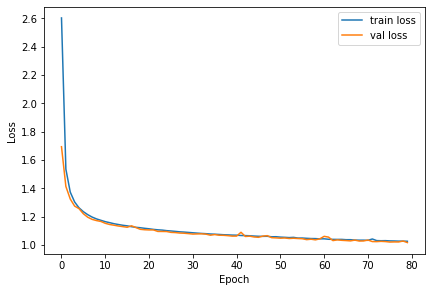

In [14]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [15]:
#Feed all datasets into the trained model to compute outputs
X_train_predict = model.predict(X_train)
X_val_predict = model.predict(X_val)
X_test_predict = model.predict(X_test)
MC_zb_predict = []
for i in range(len(MC_zb)):
    MC_zb_predict.append(model.predict(MC_zb[i]))

2022-04-26 23:05:09.286309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-26 23:05:46.507591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


### Knowledge Distillation - student model training

In [37]:
model_student = tf.keras.Sequential()
model_student.add(tf.keras.layers.InputLayer(input_shape = (18, 14, 1)))
model_student.add(tf.keras.layers.Flatten())
model_student.add(tf.keras.layers.Dense(26, activation = 'relu'))
model_student.add(tf.keras.layers.Dropout(rate = 0.3))
model_student.add(tf.keras.layers.Dense(1 , activation = 'relu'))
model_student.summary()
model_student.compile(optimizer = 'adam', loss = 'mse')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 252)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 26)                6578      
_________________________________________________________________
dropout_2 (Dropout)          (None, 26)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 27        
Total params: 6,605
Trainable params: 6,605
Non-trainable params: 0
_________________________________________________________________


In [38]:
#For transferring knowledge from teacher model to student model
history_student = model_student.fit(X_train, 100.*X_train_loss,
                                    epochs = 100,
                                    validation_data = (X_val, 100.*X_val_loss),
                                    batch_size = 256,
                                    callbacks = [
                                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
                                    ])

Epoch 1/100
 25/987 [..............................] - ETA: 4s - loss: 13740.3184 

2022-04-26 23:35:06.823983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


987/987 [==============================] - ETA: 0s - loss: 3077.5701

2022-04-26 23:35:10.636697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


987/987 [==============================] - 4s 4ms/step - loss: 3077.5701 - val_loss: 1856.7606
Epoch 2/100
987/987 [==============================] - 4s 4ms/step - loss: 2325.5640 - val_loss: 1705.0859
Epoch 3/100
987/987 [==============================] - 4s 4ms/step - loss: 2214.8979 - val_loss: 1658.4177
Epoch 4/100
987/987 [==============================] - 4s 4ms/step - loss: 2154.1006 - val_loss: 1616.2429
Epoch 5/100
987/987 [==============================] - 4s 4ms/step - loss: 2111.0266 - val_loss: 1581.0687
Epoch 6/100
987/987 [==============================] - 4s 4ms/step - loss: 2074.6936 - val_loss: 1575.9503
Epoch 7/100
987/987 [==============================] - 4s 4ms/step - loss: 2066.1294 - val_loss: 1543.5132
Epoch 8/100
987/987 [==============================] - 4s 4ms/step - loss: 1998.5728 - val_loss: 1513.2642
Epoch 9/100
987/987 [==============================] - 4s 4ms/step - loss: 1956.6814 - val_loss: 1482.2872
Epoch 10/100
987/987 [===========================

Text(0, 0.5, 'Loss')

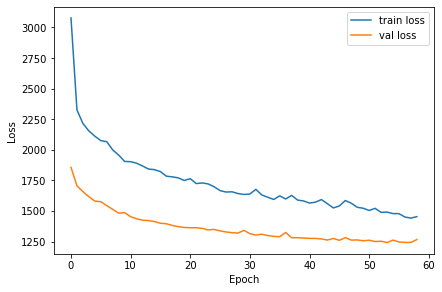

In [39]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history_student.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history_student.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [40]:
#Feed all datasets into the trained model to compute outputs
X_train_predict_student = model_student.predict(X_train)
X_test_predict_student = model_student.predict(X_test)
MC_zb_predict_student = []
for i in range(len(MC_zb)):
    MC_zb_predict_student.append(model_student.predict(MC_zb[i]))

2022-04-26 23:41:29.432533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-26 23:41:38.521229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


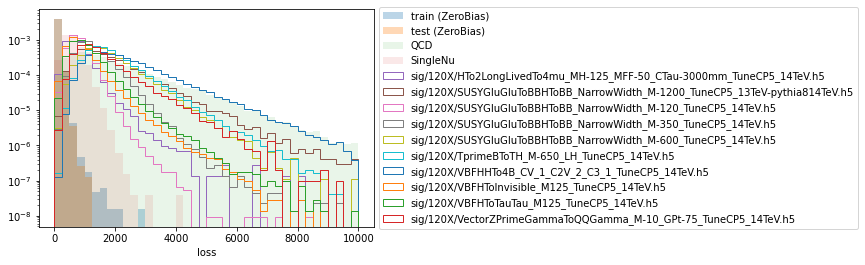

In [44]:
#Plot loss distributions
nbins = 40
rmin = 0
rmax = 10000
plt.hist(X_train_predict_student, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(X_test_predict_student, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax))
plt.hist(MC_zb_predict_student[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
plt.hist(MC_zb_predict_student[1], density = 1, bins = nbins, label = 'SingleNu', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
for i in range(40,50):
    plt.hist(MC_zb_predict_student[i], density = 1, bins = nbins, label = MC_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("loss")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

### Save model

In [24]:
#Save trained model to disk
model.save('saved_models/teacher/')

2022-04-26 23:15:03.065675: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/teacher/assets


In [42]:
#Save trained model to disk
model_student.save('saved_models/student/')

INFO:tensorflow:Assets written to: saved_models/student/assets


In [ ]:
#Retrieve saved model for test
model = tf.keras.models.load_model('saved_models/convAE_model')
model.summary()

## Evaluate performance of the trained model

### Compute and plot loss distributions

In [16]:
def custom_loss_for_pred(y_true, y_pred, choice):
    #Simple MSE
    if choice == 0:
        loss = np.mean((y_true - y_pred)**2, axis = (1, 2, 3))
        return loss
    
    #Simple MSE for de-noising model
    if choice == 1:
        loss = np.mean(y_pred**2, axis = (1, 2, 3))
        return loss
    
    #Same as custom_loss_for_train
    if choice == 2:
        loss_mse = np.mean((y_pred - y_true)**2, axis = (1, 2, 3))
        #loss_reg = np.mean((y_pred - ZB_mean)**2, axis = (1, 2, 3))
        loss_reg = np.mean(y_pred**2, axis = (1, 2, 3))
        loss = loss_mse + 0.2 * loss_reg
        return loss
    
    #Different weights in eta
    if choice == 3:
        loss = np.mean((y_true - y_pred)**2, axis = (1, 3))
        scale = np.array([0.5, 1, 2, 4, 6, 8, 10, 10, 8, 6, 4, 2, 1, 0.5])
        loss = loss * scale
        loss = np.mean(loss, axis = 1)
        return loss

In [17]:
#Compute loss scores
loss_choice = 0

X_train_loss = custom_loss_for_pred(X_train, X_train_predict, loss_choice)
X_val_loss = custom_loss_for_pred(X_val, X_val_predict, loss_choice)
X_test_loss = custom_loss_for_pred(X_test, X_test_predict, loss_choice)

MC_zb_loss = []
for i in range(len(MC_zb)):
    MC_zb_loss.append(custom_loss_for_pred(MC_zb[i], MC_zb_predict[i], loss_choice))

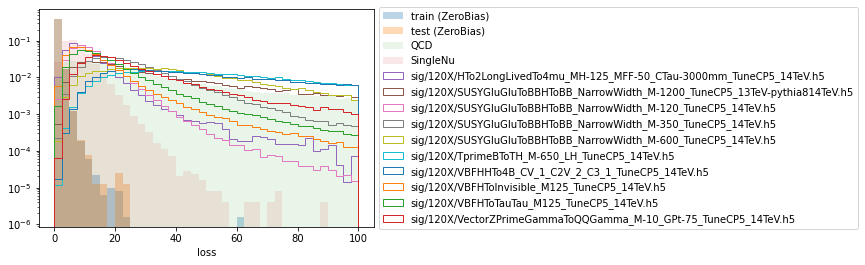

In [18]:
#Plot loss distributions
nbins = 40
rmin = 0
rmax = 100
plt.hist(X_train_loss, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(X_test_loss, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax))
plt.hist(MC_zb_loss[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
plt.hist(MC_zb_loss[1], density = 1, bins = nbins, label = 'SingleNu', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
for i in range(40,50):
    plt.hist(MC_zb_loss[i], density = 1, bins = nbins, label = MC_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("loss")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

### Plot and compare the original and reconstructed inputs

ZB test
loss = 0.8676415


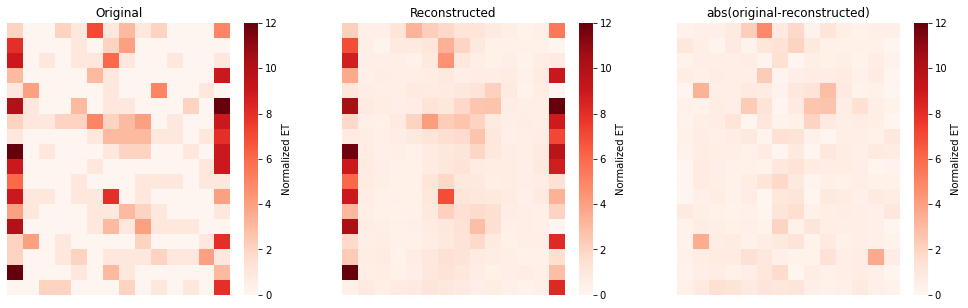

ZB test
loss = 0.6737834


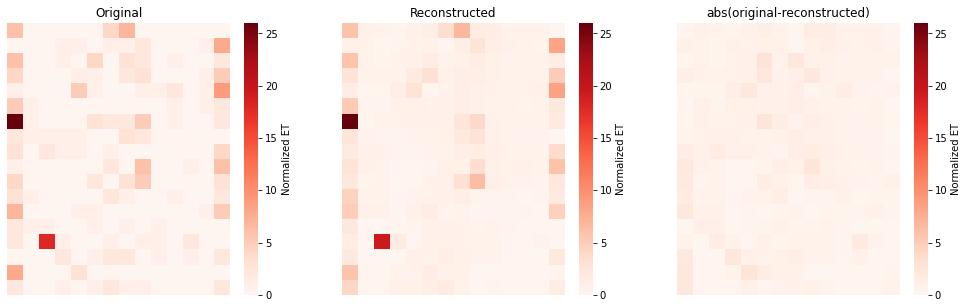

ZB test
loss = 1.3959438


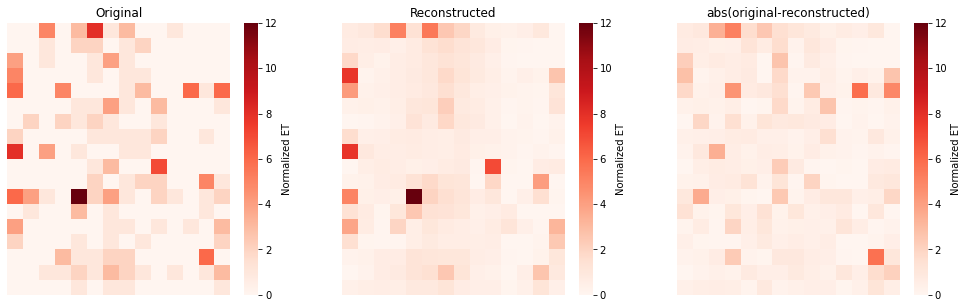

ZB test
loss = 0.93811154


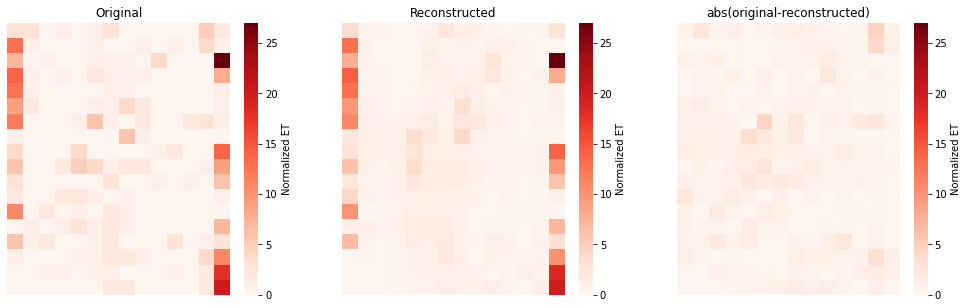

ZB test
loss = 0.8964039


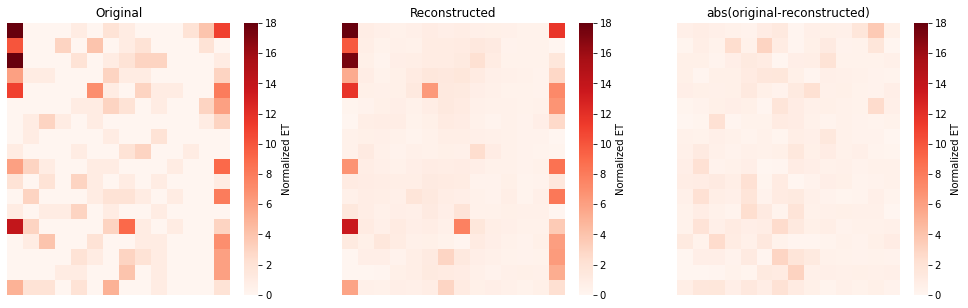

ZB test
loss = 0.9449644


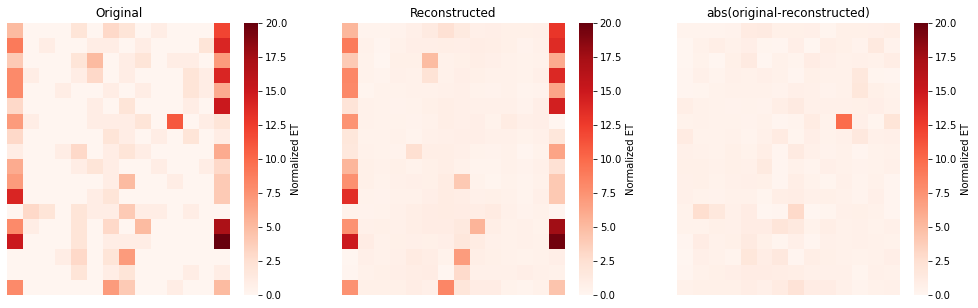

ZB test
loss = 1.2814263


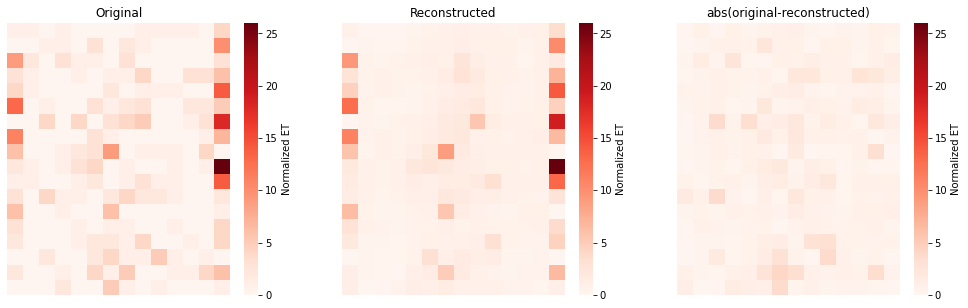

ZB test
loss = 0.46184


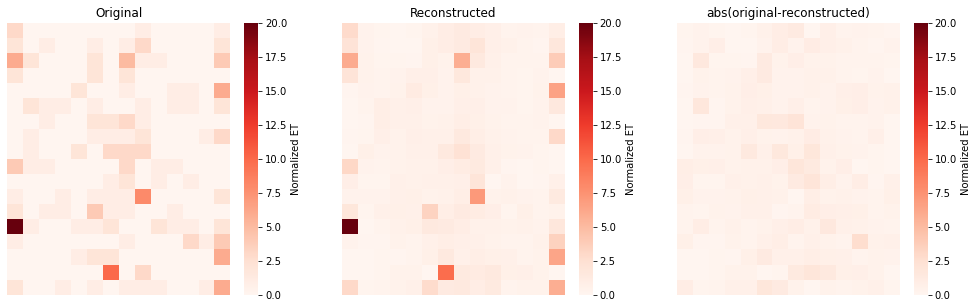

ZB test
loss = 0.5731066


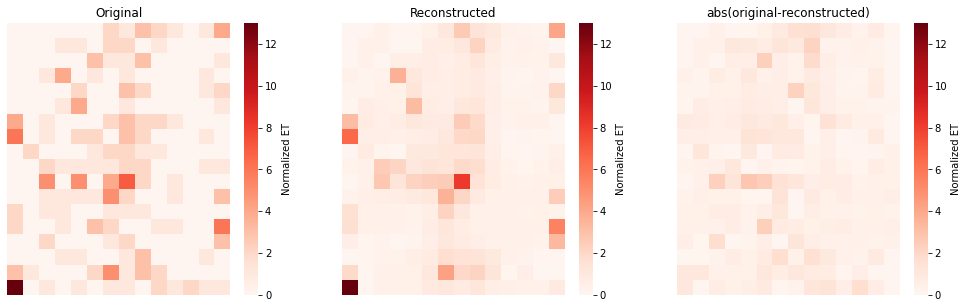

ZB test
loss = 0.73003817


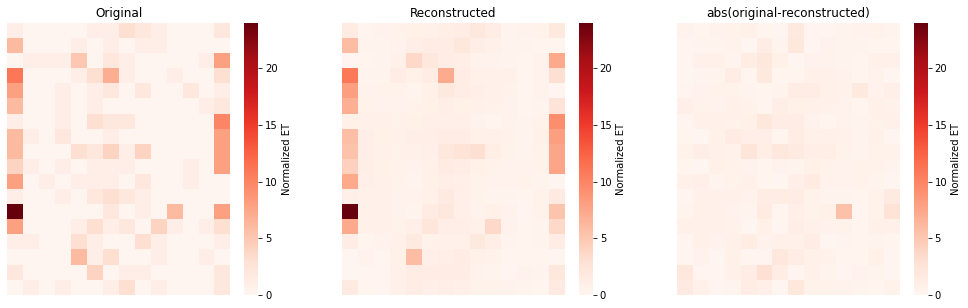

In [19]:
#Original vs Reconstructed
show_ZB = True
#show_ZB = False
n = 19
for i in range(580,590):
    fig, ax = plt.subplots(figsize = (17,17))
    if show_ZB == True:
        print('ZB test\nloss = ' + str(X_test_loss[i]))
    else:
        print(str(MC_files[n]) + '\nloss = ' + str(MC_zb_loss[n][i]))
    ax = plt.subplot(3, 3, 1)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    else:
        ax = sns.heatmap(MC_zb[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_zb[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')
    
    ax = plt.subplot(3, 3, 2)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    else:
        ax = sns.heatmap(MC_zb_predict[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_zb[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')
    
    ax = plt.subplot(3, 3, 3)
    if show_ZB == True:
        ax = sns.heatmap(np.absolute(X_test_predict[i,:,:,0] - X_test[i,:,:,0]).reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    else:
        ax = sns.heatmap(np.absolute(MC_zb_predict[n][i,:,:,0] - MC_zb[n][i,:,:,0]).reshape(18, 14), vmin = 0, vmax = MC_zb[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'Normalized ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('abs(original-reconstructed)')
    plt.show()

### Assign labels and concatenate testing sets for ROC plotting

In [20]:
#Baseline
#Assuming only the mean ZB is learned
#Take mean ZB as outputs no matter what inputs are
#Classifier of baseline = MSE(inputs, ZeroBias_mean)
ZeroBias_mean = np.mean(ZeroBias, axis = 0)

baseline_zb = np.mean((X_test - ZeroBias_mean)**2, axis = (1, 2))
baseline_mc = []
for i in range(len(MC_zb)):
    baseline_mc.append(np.mean((MC_zb[i] - ZeroBias_mean)**2, axis = (1, 2)))

In [45]:
#Assign labels for various signals (y = 1) and backgrounds (y = 0)
Y_zb = np.zeros((X_test.shape[0], 1))
Y_mc = []
for i in range(len(MC)):
    Y_mc.append(np.ones((MC_zb[i].shape[0], 1)))

#Concatenate datasets to make ROC curves, i.e. QCD/SingleNu/signals vs ZB

#True labels
Y_true = []
#Baseline scores
Y_baseline = []
#Model scores
Y_model = []
#Student model scores
Y_student = []
for i in range(len(MC)):
    Y_true.append(np.concatenate((Y_mc[i], Y_zb)))
    Y_baseline.append(np.concatenate((baseline_mc[i], baseline_zb)))
    Y_model.append(np.concatenate((MC_zb_loss[i], X_test_loss)))
    Y_student.append(np.concatenate((MC_zb_predict_student[i], X_test_predict_student)))

### Plot baseline ROC

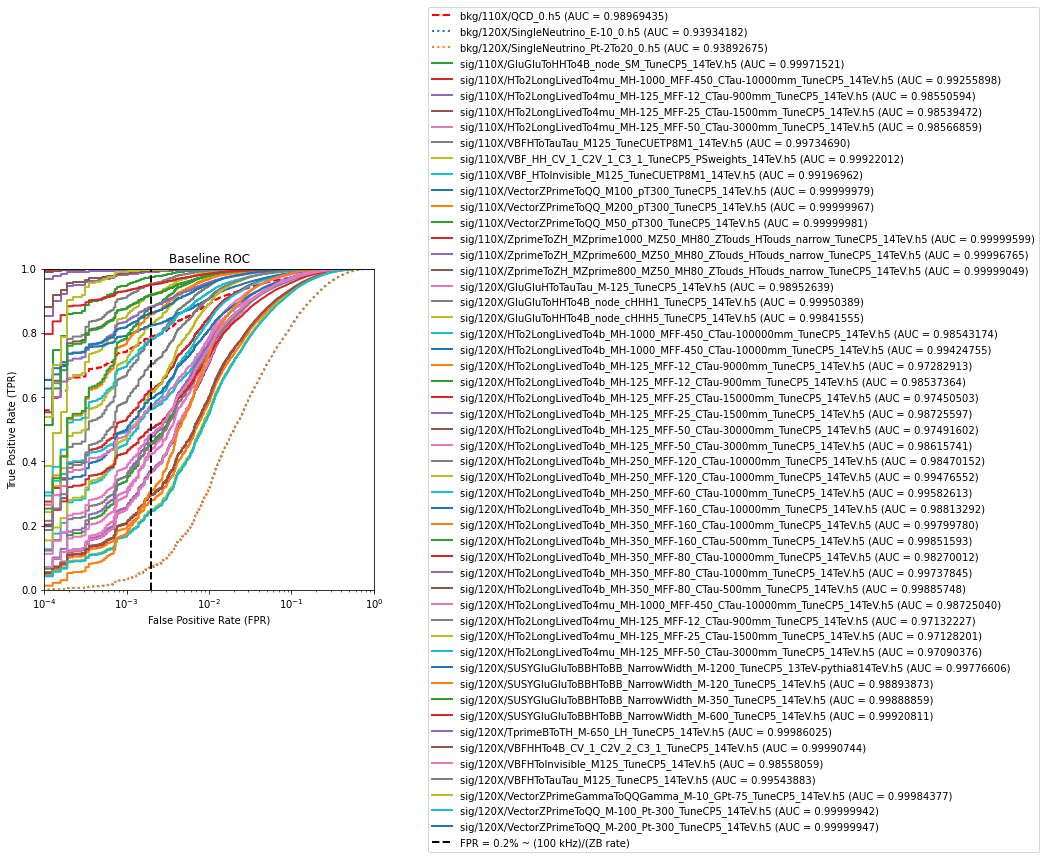

In [22]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_baseline = []
tpr_baseline = []
thresholds_baseline = []
roc_auc_baseline = []
for i in range(len(MC)):
    fpr_baseline.append(np.empty((Y_true[i].shape[0],1)))
    tpr_baseline.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_baseline.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_baseline.append(np.empty((Y_true[i].shape[0],1)))
    fpr_baseline[i], tpr_baseline[i], thresholds_baseline[i] = roc_curve(Y_true[i], Y_baseline[i])
    roc_auc_baseline[i] = auc(fpr_baseline[i], tpr_baseline[i])
    if i == 0:
        axes.plot(fpr_baseline[i], tpr_baseline[i], linestyle = '--', color = 'r', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_baseline[i]))
    elif i == 1 or i == 2:
        axes.plot(fpr_baseline[i], tpr_baseline[i], linestyle = ':', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_baseline[i]))
    else:
        axes.plot(fpr_baseline[i], tpr_baseline[i], linestyle = '-', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_baseline[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.002, 0.002], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'FPR = 0.2% ~ (100 kHz)/(ZB rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('False Positive Rate (FPR)')
axes.set_ylabel('True Positive Rate (TPR)')
axes.set_title('Baseline ROC')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Plot model ROC

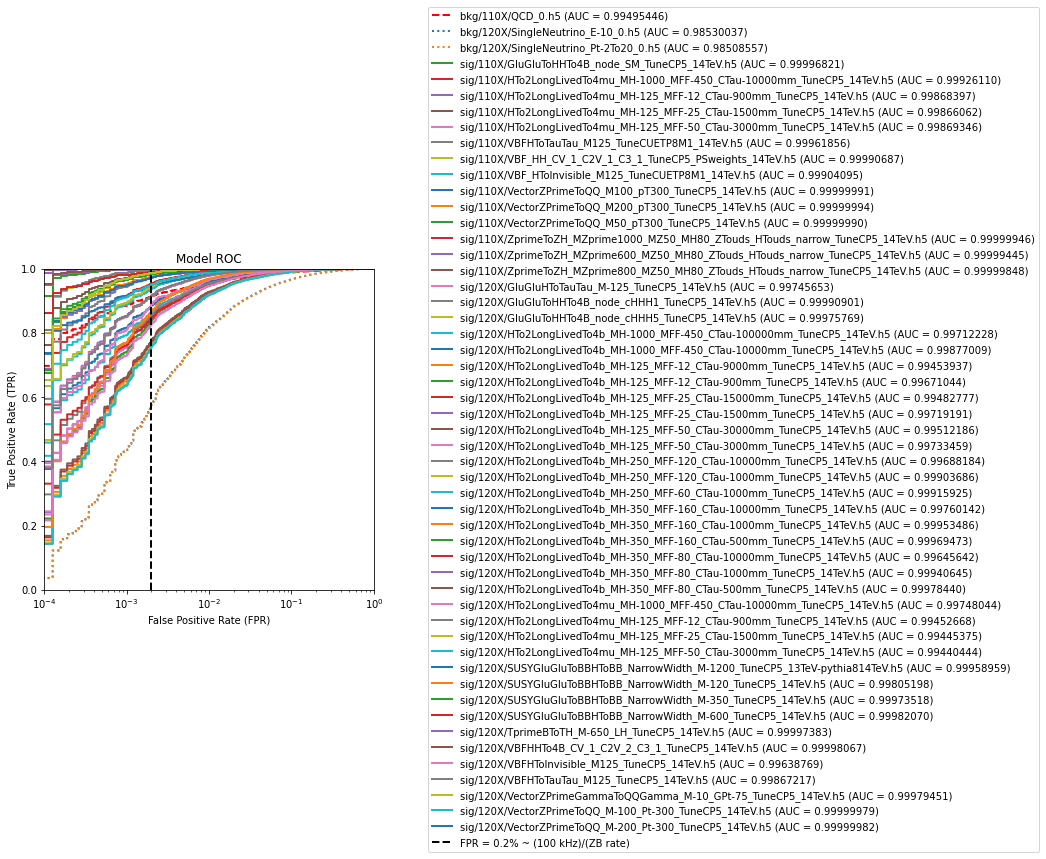

In [23]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_model = []
tpr_model = []
thresholds_model = []
roc_auc_model = []
for i in range(len(MC)):
    fpr_model.append(np.empty((Y_true[i].shape[0],1)))
    tpr_model.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_model.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_model.append(np.empty((Y_true[i].shape[0],1)))
    fpr_model[i], tpr_model[i], thresholds_model[i] = roc_curve(Y_true[i], Y_model[i])
    roc_auc_model[i] = auc(fpr_model[i], tpr_model[i])
    if i == 0:
        axes.plot(fpr_model[i], tpr_model[i], linestyle = '--', color = 'r', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
    elif i == 1 or i == 2:
        axes.plot(fpr_model[i], tpr_model[i], linestyle = ':', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
    else:
        axes.plot(fpr_model[i], tpr_model[i], linestyle = '-', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.002, 0.002], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'FPR = 0.2% ~ (100 kHz)/(ZB rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('False Positive Rate (FPR)')
axes.set_ylabel('True Positive Rate (TPR)')
axes.set_title('Model ROC')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Plot student model ROC

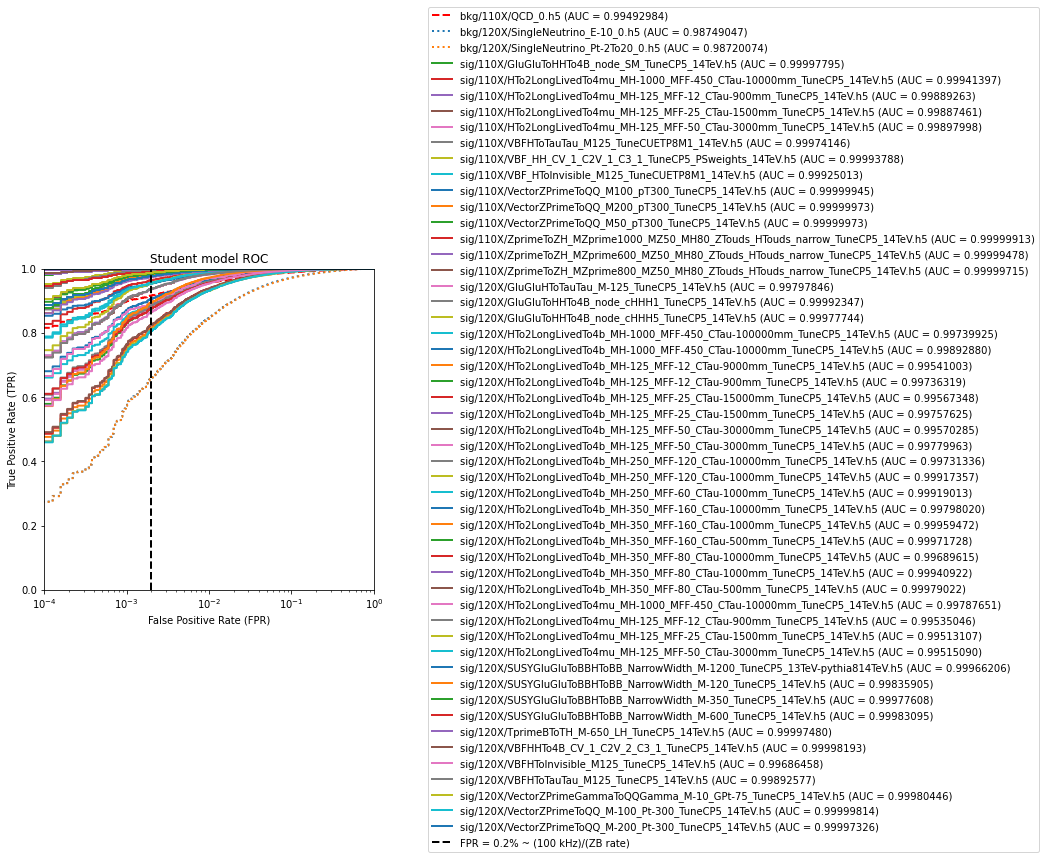

In [46]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_student = []
tpr_student = []
thresholds_student = []
roc_auc_student = []
for i in range(len(MC)):
    fpr_student.append(np.empty((Y_true[i].shape[0],1)))
    tpr_student.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_student.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_student.append(np.empty((Y_true[i].shape[0],1)))
    fpr_student[i], tpr_student[i], thresholds_student[i] = roc_curve(Y_true[i], Y_student[i])
    roc_auc_student[i] = auc(fpr_student[i], tpr_student[i])
    if i == 0:
        axes.plot(fpr_student[i], tpr_student[i], linestyle = '--', color = 'r', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_student[i]))
    elif i == 1 or i == 2:
        axes.plot(fpr_student[i], tpr_student[i], linestyle = ':', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_student[i]))
    else:
        axes.plot(fpr_student[i], tpr_student[i], linestyle = '-', lw = 2, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_student[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.002, 0.002], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'FPR = 0.2% ~ (100 kHz)/(ZB rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('False Positive Rate (FPR)')
axes.set_ylabel('True Positive Rate (TPR)')
axes.set_title('Student model ROC')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Tabulate TPR at fixed FPR = 0.2% (baseline, model, change)

In [49]:
table_tpr_baseline = []
table_tpr_model = []
table_tpr_student = []
table_tpr_change = []
for i in range(len(fpr_baseline)):
    for j in range(len(fpr_baseline[i])):
        if fpr_baseline[i][j] > 0.002:
            table_tpr_baseline.append(tpr_baseline[i][j] * 100)
            break
    for j in range(len(fpr_model[i])):
        if fpr_model[i][j] > 0.002:
            table_tpr_model.append(tpr_model[i][j] * 100)
            break
    for j in range(len(fpr_student[i])):
        if fpr_student[i][j] > 0.002:
            table_tpr_student.append(tpr_student[i][j] * 100)
            break

for i in range(len(MC)):
    #table_tpr_change.append(100 * (table_tpr_model[i] - table_tpr_baseline[i])/table_tpr_baseline[i])
    table_tpr_change.append(table_tpr_student[i] - table_tpr_model[i])

table_tpr = pd.DataFrame({'Baseline TPR@FPR=0.2%': table_tpr_baseline,
                          'CNN AE TPR@FPR=0.2%': table_tpr_model,
                          'Distilled TPR@FPR=0.2%': table_tpr_student,
                          'delta(Distilled, CNN AE)': table_tpr_change},
                        index = MC_files)
table_tpr = table_tpr.sort_values(by = 'CNN AE TPR@FPR=0.2%', ascending = False)

pd.set_option('display.max_colwidth', None)
table_tpr

,Baseline TPR@FPR=0.2%,CNN AE TPR@FPR=0.2%,Distilled TPR@FPR=0.2%,"delta(Distilled, CNN AE)"
sig/120X/VectorZPrimeToQQ_M-200_Pt-300_TuneCP5_14TeV.h5,100.000000,100.000000,99.989155,-0.010845
sig/110X/VectorZPrimeToQQ_M100_pT300_TuneCP5_14TeV.h5,100.000000,100.000000,100.000000,0.000000
sig/120X/VectorZPrimeToQQ_M-100_Pt-300_TuneCP5_14TeV.h5,99.997415,100.000000,99.989661,-0.010339
sig/110X/ZprimeToZH_MZprime1000_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5,99.964365,100.000000,99.997904,-0.002096
sig/110X/VectorZPrimeToQQ_M50_pT300_TuneCP5_14TeV.h5,100.000000,100.000000,100.000000,0.000000
sig/110X/VectorZPrimeToQQ_M200_pT300_TuneCP5_14TeV.h5,100.000000,100.000000,100.000000,0.000000
sig/110X/ZprimeToZH_MZprime800_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5,99.933529,99.995971,99.983886,-0.012086
sig/110X/ZprimeToZH_MZprime600_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5,99.750894,99.981920,99.973884,-0.008036
sig/120X/VBFHHTo4B_CV_1_C2V_2_C3_1_TuneCP5_14TeV.h5,99.346661,99.924991,99.894553,-0.030438
sig/110X/GluGluToHHTo4B_node_SM_TuneCP5_14TeV.h5,97.370864,99.862793,99.866828,0.004036
